# # Treinamento do Modelo de Detecção de Boletos

### Imports

In [33]:
import pandas as pd
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import shap
import os


In [34]:
MODEL_PATH = r'C:\Users\toyst\Documents\Projetos\Projeto da Residência - Banco do Brasil(2025.2)\backend\detectaBB_backend\modelo_boleto.pkl'

### # 2. Carregamento e Prepara os Dados

In [35]:
try:
    with open('completos.json', 'r', encoding='utf-8') as f:
        dados = json.load(f)
except FileNotFoundError:
    print("Erro: Arquivo completos.json não encontrado.")
    # exit(1)
    raise

df = pd.DataFrame(dados)
print('Dados carregados:')
print("Colunas originais:", df.columns.tolist())

print(df.head())


Dados carregados:
Colunas originais: ['banco', 'codigoBanco', 'agencia', 'valor', 'linhaDigitavel', 'classe']
  banco codigoBanco agencia   valor  \
0  Itaú         341    0773  890.00   
1  Itaú         341    0773  467.00   
2  Itaú         341    0773  230.00   
3  Itaú         341    0773  986.00   
4  Itaú         341    0773  766.00   

                                      linhaDigitavel  \
0  34190.00000 00000.000000 00000.000000 0 000000...   
1  34190.00000 00000.000000 00000.000000 0 000000...   
2  34190.00000 00000.000000 00000.000000 0 000000...   
3  34190.00000 00000.000000 00000.000000 0 000000...   
4  34190.00000 00000.000000 00000.000000 0 000000...   

                       classe  
0  caracteristicasVerdadeiras  
1  caracteristicasVerdadeiras  
2  caracteristicasVerdadeiras  
3  caracteristicasVerdadeiras  
4  caracteristicasVerdadeiras  


In [36]:
# Guardar o nome original do banco (string) antes de mapear para id numérico
if 'banco' in df.columns:
    df['banco_nome_original'] = df['banco']  # cópia para regras
else:
    df['banco_nome_original'] = None

### # Mapear bancos para índices numéricos

In [ ]:



# Mapeamento de nomes -> id (mantive o seu mapeamento)
mapeamento_bancos = {
    'Banco do Brasil': 0,
    'Itaú': 1,
    'Bradesco': 2,
    'Santander': 3,
    'Caixa Econômica': 4,
    'Banco Digio S.A.': 5,
    'CM CAPITAL MARKETS CORRETORA DE CÂMBIO, TÍTULOS E VALORES MOBILIÁRIOS LTDA': 6,
    'Banco Clássico S.A.': 7,
    'Credialiança Cooperativa de Crédito Rural': 8,
    'CREDICOAMO CREDITO RURAL COOPERATIVA': 9,
    # Bancos falsos / outros
    'OLIVEIRA TRUST DISTRIBUIDORA DE TÍTULOS E VALORES MOBILIARIOS S.A.': 10,
    'Pagseguro Internet S.A. – PagBank': 11,
    'NU Pagamentos S.A. – Nubank': 12,
    'ATIVA INVESTIMENTOS S.A. CORRETORA DE TÍTULOS, CÂMBIO E VALORES': 13,
    'Banco Inbursa S.A.': 14,
    'SOROCRED CRÉDITO, FINANCIAMENTO E INVESTIMENTO S.A.': 15,
    'Banco Finaxis S.A.': 16,
    'SOCRED S.A. – SOCIEDADE DE CRÉDITO AO MICROEMPREENDEDOR E À EMPRESA DE PEQUENO P': 17
}
# aplicar mapeamento (se for string no dataset)
if df['banco'].dtype == object:
    df['banco'] = df['banco'].map(mapeamento_bancos).fillna(0).astype(float)

# Mapear target
df['classe'] = df['classe'].map({
    'caracteristicasVerdadeiras': 1,
    'caracteristicasFalsas': 0
}).astype(float)

In [38]:
print(df.columns.tolist())


['banco', 'codigoBanco', 'agencia', 'valor', 'linhaDigitavel', 'classe', 'banco_nome_original']


### # Processar linha digitável e selecionar as features

In [ ]:


df['linhaDigitavel'] = df['linhaDigitavel'].astype(str).str.replace(' ', '').str.replace('.', '')
df['linha_codBanco'] = df['linhaDigitavel'].str.slice(0, 3).fillna('0').astype(int)
df['linha_moeda'] = df['linhaDigitavel'].str.slice(3, 4).fillna('9').astype(int)
df['linha_valor'] = df['linhaDigitavel'].str.slice(-10).fillna('0').astype(int)

# Converter colunas principais para tipos consistentes
for col in ['codigoBanco', 'agencia', 'valor']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# features usadas pelo modelo
features = ['banco', 'codigoBanco', 'agencia', 'valor', 'linha_codBanco', 'linha_moeda', 'linha_valor']

# garantir colunas existentes (criar zeros caso não exista)
for c in features:
    if c not in df.columns:
        df[c] = 0

X = df[features].astype(float)
y = df['classe'].astype(int)

print("Shape X, y:", X.shape, y.shape)
print("Primeiras linhas das features:\n", X.head())

Shape X, y: (500, 7) (500,)
Primeiras linhas das features:
    banco  codigoBanco  agencia  valor  linha_codBanco  linha_moeda  \
0    1.0        341.0    773.0  890.0           341.0          9.0   
1    1.0        341.0    773.0  467.0           341.0          9.0   
2    1.0        341.0    773.0  230.0           341.0          9.0   
3    1.0        341.0    773.0  986.0           341.0          9.0   
4    1.0        341.0    773.0  766.0           341.0          9.0   

   linha_valor  
0      89000.0  
1      46700.0  
2      23000.0  
3      98600.0  
4      76600.0  


### Treinar o modelo

In [ ]:


# Se já tiver o pkl salvo, opcionalmente carrega.
if os.path.exists(MODEL_PATH):
    try:
        model = pickle.load(open(MODEL_PATH, 'rb'))
        print("Modelo carregado de", MODEL_PATH)
    except Exception as e:
        print("Falha ao carregar modelo salvo, vou treinar novo. Erro:", e)
        model = None
else:
    model = None

if model is None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42, n_estimators=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Acurácia:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['Falso','Verdadeiro']))
    # salvar modelo
    pickle.dump(model, open(MODEL_PATH, 'wb'))
    print("Modelo treinado e salvo em", MODEL_PATH)
else:
    # se carregou, opcional: avaliar contra X_test (se você tiver X_test separado)
    print("Usando modelo carregado (não re-treinei aqui).")


Modelo carregado de C:\Users\toyst\Documents\Projetos\Projeto da Residência - Banco do Brasil(2025.2)\backend\detectaBB_backend\modelo_boleto.pkl
Usando modelo carregado (não re-treinei aqui).


## Análise com SHAP - XAI

In [ ]:
# 5. Análise com SHAP
explainer = shap.TreeExplainer(model)


## Regras determinísticas

In [ ]:
# Mapeamento de nome->código do banco (string de 3 dígitos) — ajuste se preciso
bancos_validos = {
    "Banco do Brasil": "001",
    "Bradesco": "237",
    "Itaú": "341",
    "Caixa Econômica": "104",
    "Santander": "033",
    
}
# Map id -> nome 
id_to_name = {v: k for k, v in mapeamento_bancos.items()}

agencias_validas = {
    "Banco do Brasil": ["2889", "2811", "0007", "0325", "1620"],
    "Bradesco": ["3201", "2560", "6083", "2322", "2300"],
    "Itaú": ["0364", "3174", "0814", "1594", "0773"],
    "Caixa Econômica": ["0045", "0047", "3484", "0923", "0867"],
    "Santander": ["3295", "4419", "4159", "4048", "4052"]
}

## # Plotar resumo para a classe 'Falso' (índice 0)

In [ ]:


def regras_simples_check(dado_series):
    """Retorna dicionário com checks de regras e mensagens amigáveis (True = passa)."""
    # dado_series é uma Series (1 amostra com colunas features)
    res = {}
    # 1) código do banco na linha vs codigoBanco (comparing ints)
    try:
        linha_cod = int(dado_series['linha_codBanco'])
        cod = int(dado_series['codigoBanco'])
        res['codigo_na_linha'] = (linha_cod == cod)
    except:
        res['codigo_na_linha'] = False

    # 2) moeda (esperamos 9 na sua regra original)
    try:
        res['moeda_igual_9'] = (int(dado_series['linha_moeda']) == 9)
    except:
        res['moeda_igual_9'] = False

    # 3) valor no final da linha corresponde ao valor (centavos)
    try:
        valor_cent = int(round(float(dado_series['valor']) * 100))
        res['valor_bate'] = (int(dado_series['linha_valor']) == valor_cent)
    except:
        res['valor_bate'] = False

    # 4) agencia pertence ao banco (se soubermos o banco)
    try:
        banco_id = int(dado_series['banco'])
        banco_nome = id_to_name.get(banco_id, None)
        if banco_nome and banco_nome in agencias_validas:
            res['agencia_valida'] = (str(int(dado_series['agencia'])).zfill(4) in agencias_validas[banco_nome])
        else:
            res['agencia_valida'] = None  # não sabemos
    except:
        res['agencia_valida'] = None

    return res

## Função robusta para pegar vetor SHAP para a amostra e classe predita

In [ ]:
def pegar_shap_vector_para_amostra(shap_exp, pred):
    """Retorna 1D numpy array de shap values correspondente à classe pred (robusto para dims)."""
    vals = shap_exp.values  # pode ser (n_samples, n_classes, n_features) ou (n_samples, n_features)
    # garantir primeiro eixo seja amostra 0 (já estamos pedindo explainer(dado) -> 1 amostra)
    if isinstance(vals, np.ndarray):
        if vals.ndim == 3:
            # (1, n_classes, n_features)
            v = vals[0][int(pred)]
        elif vals.ndim == 2:
            # (1, n_features) ou (n_samples, n_features)
            v = vals[0]
        else:
            v = np.asarray(vals).ravel()
    else:
        # fallback: tentar converter
        v = np.asarray(vals).ravel()
    return np.asarray(v, dtype=float)


In [ ]:


def explicar_predicao(explainer, dado_df, features, model, thresh_shap=0.001):
    """
    dado_df: DataFrame 1xN com colunas = features
    retorna (texto_para_usuario, debug_dict)
    """
    debug = {}
    # pred e prob
    pred = int(model.predict(dado_df)[0])
    prob = model.predict_proba(dado_df)[0].tolist()
    debug['pred'] = pred
    debug['prob'] = prob

    # regras
    checks = regras_simples_check(dado_df.iloc[0])
    debug['rules'] = checks

    # SHAP
    shap_exp = explainer(dado_df)
    try:
        shap_vec = pegar_shap_vector_para_amostra(shap_exp, pred)  # 1D
        debug['shap_vec'] = shap_vec.tolist()
    except Exception as e:
        shap_vec = None
        debug['shap_error'] = str(e)

    # montar mensagens amigáveis:
    msgs = []
    # priorize regras determinísticas (são claras e rastreáveis)
    if checks.get('codigo_na_linha') is False:
        msgs.append("➡ O código do banco na linha digitável não confere com o código informado.")
    if checks.get('moeda_igual_9') is False:
        msgs.append("➡ O dígito de moeda na linha digitável está diferente do esperado.")
    if checks.get('valor_bate') is False:
        msgs.append("➡ O valor no final da linha digitável não confere com o valor informado no boleto.")
    if checks.get('agencia_valida') is False:
        msgs.append("➡ A agência informada provavelmente não pertence ao banco indicado.")
    # se alguma regra devolveu None (não sabemos), não mostramos nada automático

    # Agora usar shap_vec para completar explicações (sem termos técnicos)
    if shap_vec is not None:
        for i, v in enumerate(shap_vec):
            if abs(v) > thresh_shap:
                fname = features[i]
                if fname == 'banco':
                    if v < 0:
                        msgs.append("➡ O banco informado tem evidência negativa (fez o modelo inclinar para 'falso').")
                    else:
                        msgs.append("➡ O banco informado tem evidência positiva (ajudou a indicar 'verdadeiro').")
                elif fname == 'codigoBanco':
                    if v < 0:
                        msgs.append("➡ O código do banco pushou a decisão para 'falso'.")
                elif fname == 'valor':
                    if v < 0:
                        msgs.append("➡ O valor observado diminuiu a confiança do modelo (sinal de suspeita).")
                elif fname == 'agencia':
                    if v < 0:
                        msgs.append("➡ A agência contribuiu para indicar 'falso'.")

    # deduplicar mensagens mantendo ordem
    seen = set()
    msgs_ord = []
    for m in msgs:
        if m not in seen:
            msgs_ord.append(m)
            seen.add(m)

    # montar texto final curto para usuário
    status = "VERDADEIRO ✅" if pred == 1 else "FALSO ❌"
    if msgs_ord:
        texto_usuario = f"Resultado da análise: {status}\n\nPrincipais motivos detectados:\n" + "\n".join(msgs_ord)
    else:
        texto_usuario = f"Resultado da análise: {status}\n\nNenhuma inconsistência clara foi detectada automaticamente."

    # DEBUG: incluir shap_exp e base_values se quiser log
    debug['shap_base'] = getattr(shap_exp, 'base_values', None)
    return texto_usuario, debug, shap_exp


### Testes com exemplos


Processando boleto 1
Resultado da análise: FALSO ❌

Principais motivos detectados:
➡ O código do banco na linha digitável não confere com o código informado.
➡ O dígito de moeda na linha digitável está diferente do esperado.
➡ O banco informado tem evidência positiva (ajudou a indicar 'verdadeiro').
➡ O código do banco pushou a decisão para 'falso'.

[LOG TÉCNICO resumido]
pred: 0 prob: [0.97, 0.03]
rules: {'codigo_na_linha': False, 'moeda_igual_9': False, 'valor_bate': True, 'agencia_valida': None}
shap_vec (top 7): [ 0.00361 -0.00361]
Gerando gráfico (waterfall).


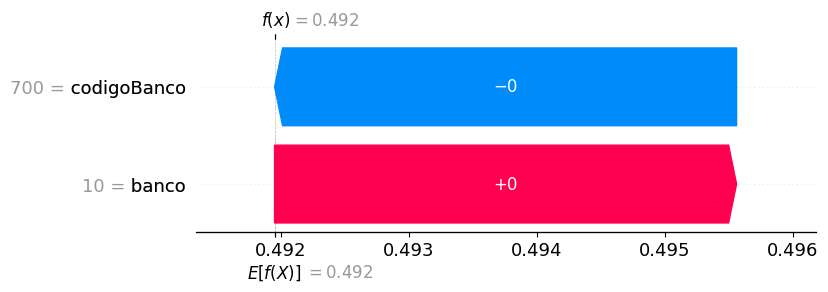


Processando boleto 2
Resultado da análise: FALSO ❌

Principais motivos detectados:
➡ O código do banco na linha digitável não confere com o código informado.
➡ O dígito de moeda na linha digitável está diferente do esperado.
➡ O valor no final da linha digitável não confere com o valor informado no boleto.
➡ O banco informado tem evidência positiva (ajudou a indicar 'verdadeiro').
➡ O código do banco pushou a decisão para 'falso'.

[LOG TÉCNICO resumido]
pred: 0 prob: [0.98, 0.02]
rules: {'codigo_na_linha': False, 'moeda_igual_9': False, 'valor_bate': False, 'agencia_valida': None}
shap_vec (top 7): [ 0.002879 -0.002879]
Gerando gráfico (waterfall).


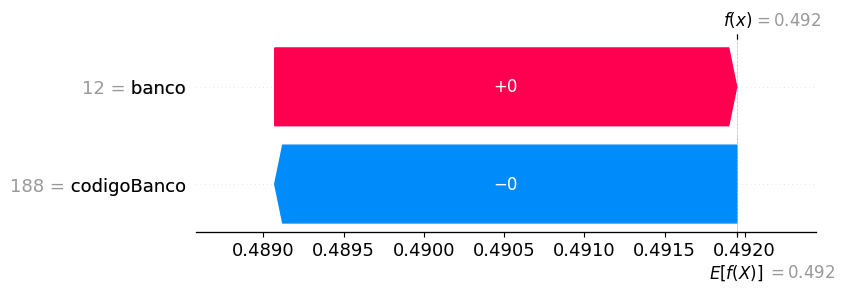

In [ ]:
testes = [
    {  # Falso: OLIVEIRA TRUST (você disse que é falso)
        'banco': 10, 'codigoBanco': 700, 'agencia': 712, 'valor': 834629.43,
        'linha_codBanco': 111, 'linha_moeda': 0, 'linha_valor': 83462943
    },
    {  # Verdadeiro: (exemplo que você acha que é verdadeiro; se os dados não baterem, a regra detecta)
        'banco': 12, 'codigoBanco': 188, 'agencia': 101, 'valor': 731538.0,
        'linha_codBanco': 260, 'linha_moeda': 3, 'linha_valor': 94228611
    }
]
features = ['banco', 'codigoBanco', 'agencia', 'valor', 'linha_codBanco', 'linha_moeda', 'linha_valor']

for i, teste in enumerate(testes, start=1):
    print("\n" + "="*40)
    print(f"Processando boleto {i}")
    # garantir somente colunas/features esperadas
    dado_teste = pd.DataFrame([teste])[features].astype(float)

    texto_usuario, debug, shap_exp = explicar_predicao(explainer, dado_teste, features, model, thresh_shap=0.001)
    print(texto_usuario)
    # mostrar debug técnico (útil para você)
    print("\n[Algo mais técnico resumido]")
    print("pred:", debug.get('pred'), "prob:", debug.get('prob'))
    print("rules:", debug.get('rules'))
    if 'shap_vec' in debug:
        print("shap_vec (top 7):", np.round(np.array(debug['shap_vec']), 6))
    if 'shap_error' in debug:
        print("shap_error:", debug['shap_error'])

    # Tentar plotar um gráfico SHAP amigável (waterfall) — opcional e protegido por try/except
    try:
        # obter vetor de shap para a classe predita (1D)
        pred = int(debug.get('pred'))
        shap_vec = pegar_shap_vector_para_amostra(shap_exp, pred)
        base_val = shap_exp.base_values[0] if np.ndim(shap_exp.base_values) == 0 else shap_exp.base_values[0][pred]
        # criar Explanation manual (compatível com waterfall)
        expl_for_plot = shap.Explanation(values=shap_vec, base_values=base_val,
                                         data=dado_teste.iloc[0].to_numpy(), feature_names=features)
        print("Gerando gráfico (waterfall).")
        shap.plots.waterfall(expl_for_plot, max_display=len(features))
        plt.show()
    except Exception as e:
        print("Falha ao gerar gráfico SHAP (somente log):", str(e))
